# EDA installments_payments
In this analysis, we compare the installment payment history of defaulters and non-defaulters. Defaulters tend to make payments closer to the application date of their current loan, while non-defaulters maintain more consistent, timely repayments. Interestingly, some loans repaid on time or early still default, and some repaid late are still accepted, raising the question of why late payments are tolerated in certain contracts.

In [2]:
import numpy as np
import pandas as pd
import gc
import time
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from contextlib import contextmanager
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 
import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


# Read files

In [3]:
install_pay = pd.read_csv(r'D:\python\visualize\final_project\dseb63_final_project_DP_dataset\dseb63_final_project_DP_dataset\dseb63_installments_payments.csv')

In [4]:
train = pd.read_csv(r'D:\python\visualize\final_project\dseb63_final_project_DP_dataset\dseb63_final_project_DP_dataset\dseb63_application_train.csv')

# Basic analyzing

In [5]:
print(f'The shape of installments_payments.csv is: {install_pay.shape}')
print('-'*100)
print(f'Number of unique SK_ID_PREV in installments_payments.csv are: {len(install_pay.SK_ID_PREV.unique())}')
print(f'Number of unique SK_ID_CURR in installments_payments.csv are: {len(install_pay.SK_ID_CURR.unique())}')
print('-'*100)
print(f'Number of overlapping SK_ID_CURR in application_train.csv and installments_payments.csv are: {len(set(train.SK_ID_CURR.unique()).intersection(set(install_pay.SK_ID_CURR.unique())))}')
print('-'*100)
print(f'Number of duplicate values in installments_payments: {install_pay.shape[0] - install_pay.duplicated().shape[0]}')
print('-'*100)
display(install_pay.head(5))

The shape of installments_payments.csv is: (7744758, 8)
----------------------------------------------------------------------------------------------------
Number of unique SK_ID_PREV in installments_payments.csv are: 549020
Number of unique SK_ID_CURR in installments_payments.csv are: 180734
----------------------------------------------------------------------------------------------------
Number of overlapping SK_ID_CURR in application_train.csv and installments_payments.csv are: 144408
----------------------------------------------------------------------------------------------------
Number of duplicate values in installments_payments: 0
----------------------------------------------------------------------------------------------------


,SK_ID_PREV,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,SK_ID_CURR
0,1054186,1.0,6,-1180.0,-1187.0,6948.360,6948.360,147397.0
1,2452854,1.0,21,-546.0,-552.0,11302.605,11302.605,147397.0
2,1054186,1.0,2,-1300.0,-1307.0,6948.360,6948.360,147397.0
3,1682318,1.0,2,-240.0,-243.0,7374.510,7374.510,147397.0
4,2452854,1.0,10,-876.0,-882.0,11302.605,11302.605,147397.0


In [6]:
install_pay['DAYS_PAID_EARLIER'] = install_pay['DAYS_INSTALMENT']-install_pay['DAYS_ENTRY_PAYMENT']

# 0: 1: late payment, 0 otherwise
install_pay['PAID_STATUS'] = install_pay['DAYS_PAID_EARLIER'].map(lambda x: 1 if x<0 else 0)

In [7]:
install_pay['EXCESS_PAYMENT'] = install_pay['AMT_PAYMENT']-install_pay['AMT_INSTALMENT']
# 1 : excess payment, 0 otherwise
install_pay['EXCESS_PAYMENT_STATUS'] = install_pay['EXCESS_PAYMENT'].map(lambda x: 1 if x>0 else x)

In [8]:
install_pay.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7744758 entries, 0 to 7744757
Data columns (total 12 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int64  
 1   NUM_INSTALMENT_VERSION  float64
 2   NUM_INSTALMENT_NUMBER   int64  
 3   DAYS_INSTALMENT         float64
 4   DAYS_ENTRY_PAYMENT      float64
 5   AMT_INSTALMENT          float64
 6   AMT_PAYMENT             float64
 7   SK_ID_CURR              float64
 8   DAYS_PAID_EARLIER       float64
 9   PAID_STATUS             int64  
 10  EXCESS_PAYMENT          float64
 11  EXCESS_PAYMENT_STATUS   float64
dtypes: float64(9), int64(3)
memory usage: 709.1 MB


- SK_ID_PREV: ID of previous credit in Home Credit related to loan in our sample
- SK_ID_CURR: ID of loan in our sample
- NUM_INSTALMENT_VERSION: Version of installment calendar (0 is for credit card) of previous credit. Change of installment version from month to month signifies that some parameter of payment calendar has changed
- NUM_INSTALMENT_NUMBER : On which installment we observe payment (lan tra gop so bao nhieu)
- DAYS_INSTALMENT: When the installment of previous credit was supposed to be paid (relative to application date of current loan),time only relative to the application (ngay tra gop)
- DAYS_ENTRY_PAYMENT: When was the installments of previous credit paid actually (ngay ma khach hang that su tra)
- AMT_INSTALMENT: What was the prescribed installment amount of previous credit on this installment (luong tien tra gop dang ra khach hang phai tra)
- AMT_PAYMENT: What the client actually paid on previous credit on this installment ( luong tien tra gop ma khach hang that su tra)

# Checking missing values

In [9]:
def nan_df_create(data):
    
    '''
    Function to create a dataframe of percentage of NaN values for each column of the dataframe
    
    Inputs:
        data: 
            DataFrame
    
    Returns:
        DataFrame of NaN percentages
    '''
    
    nan_percentages = data.isna().sum() * 100 / len(data)
    df = pd.DataFrame({'column' : nan_percentages.index, 'percent' : nan_percentages.values})
    
    #sorting the dataframe by decreasing order of percentage of NaN values
    df.sort_values(by = 'percent', ascending = False, inplace = True)
    
    return df

In [10]:
install_pay.isna().sum()

SK_ID_PREV                   0
NUM_INSTALMENT_VERSION       0
NUM_INSTALMENT_NUMBER        0
DAYS_INSTALMENT              0
DAYS_ENTRY_PAYMENT        1639
AMT_INSTALMENT               1
AMT_PAYMENT               1639
SK_ID_CURR                   1
DAYS_PAID_EARLIER         1639
PAID_STATUS                  0
EXCESS_PAYMENT            1639
EXCESS_PAYMENT_STATUS     1639
dtype: int64

In [11]:
print('-'*100)
print("Columns with NaN values and their percentages:")
installments_payments_nan = nan_df_create(install_pay)
display(installments_payments_nan[installments_payments_nan.percent != 0])
print('-'*100)
del installments_payments_nan

----------------------------------------------------------------------------------------------------
Columns with NaN values and their percentages:


,column,percent
4,DAYS_ENTRY_PAYMENT,0.021163
6,AMT_PAYMENT,0.021163
8,DAYS_PAID_EARLIER,0.021163
10,EXCESS_PAYMENT,0.021163
11,EXCESS_PAYMENT_STATUS,0.021163
5,AMT_INSTALMENT,0.000013
7,SK_ID_CURR,0.000013


----------------------------------------------------------------------------------------------------


These columns also contain very minimal proportion of NaN values, i.e only 0.02%, so it is not of much concern.

# Merging TARGET column

In [12]:
train.head()

,Unnamed: 0,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,SK_ID_CURR
0,0,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,278621
1,1,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,139008
2,2,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,138348
3,3,0,Cash loans,M,N,Y,0,99000.0,490495.5,27517.5,...,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0,64140
4,4,0,Cash loans,M,Y,Y,0,360000.0,1530000.0,42075.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,219374


In [13]:
install_merged = pd.merge(train[['TARGET','SK_ID_CURR']],install_pay, on = 'SK_ID_CURR', how = 'left')
install_merged.head()



,TARGET,SK_ID_CURR,SK_ID_PREV,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,DAYS_PAID_EARLIER,PAID_STATUS,EXCESS_PAYMENT,EXCESS_PAYMENT_STATUS
0,0,278621,1810518.0,1.0,2.0,-686.0,-690.0,98356.995,98356.995,4.0,0.0,0.0,0.0
1,0,278621,1810518.0,1.0,3.0,-656.0,-661.0,98356.995,98356.995,5.0,0.0,0.0,0.0
2,0,278621,2396755.0,1.0,4.0,-2220.0,-2226.0,6737.310,6737.310,6.0,0.0,0.0,0.0
3,0,278621,2396755.0,1.0,9.0,-2070.0,-2071.0,6737.310,6737.310,1.0,0.0,0.0,0.0
4,0,278621,2396755.0,1.0,5.0,-2190.0,-2199.0,6737.310,6737.310,9.0,0.0,0.0,0.0


# Correlation Matrix of Features


In [14]:
class correlation_matrix:
    '''
    Class to plot heatmap of Correlation Matrix and print Top Correlated Features with Target.
    Contains three methods:
        1. init method
        2. plot_correlation_matrix method
        3. target_top_corr method
    '''
    
    def __init__(self, data, columns_to_drop, figsize = (25,23), mask_upper = True, tight_layout = True, 
                  linewidth = 0.1, fontsize = 10, cmap = 'Blues'):  
        '''  
        Function to initialize the class members. 
        
        Inputs:
            data: DataFrame
                The DataFrame from which to build correlation matrix
            columns_to_drop: list
                Columns which have to be dropped while building the correlation matrix (for example the Loan ID)
            figsize: tuple, default = (25,23)
                Size of the figure to be plotted
            mask_upper: bool, default = True
                Whether to plot only the lower triangle of heatmap or plot full.
            tight_layout: bool, default = True
                Whether to keep tight layout or not
            linewidth: float/int, default = 0.1
                The linewidth to use for heatmap
            fontsize: int, default = 10
                The font size for the X and Y tick labels
            cmap: str, default = 'Blues'
                The colormap to be used for heatmap

        Returns:
            None
        '''
        
        self.data = data
        self.columns_to_drop = columns_to_drop
        self.figsize = figsize
        self.mask_upper = mask_upper
        self.tight_layout = tight_layout
        self.linewidth = linewidth
        self.fontsize = fontsize
        self.cmap = cmap 
                 
    def plot_correlation_matrix(self):
        '''
        Function to plot the Correlation Matrix Heatmap
        
        Inputs:
            self
        
        Returns:
            None
        '''
        
        print('-' * 100)
        #building the correlation dataframe
        self.corr_data = self.data.drop(self.columns_to_drop + ['TARGET'], axis = 1).corr()

        if self.mask_upper:
            #masking the heatmap to show only lower triangle. This is to save the RAM.
            mask_array = np.ones(self.corr_data.shape)
            mask_array = np.triu(mask_array)
        else:
            mask_array = np.zeros(self.corr_data.shape)

        plt.figure(figsize = self.figsize, tight_layout = self.tight_layout)
        sns.heatmap(self.corr_data, annot = False, mask = mask_array, linewidth = self.linewidth, cmap = self.cmap)
        plt.xticks(rotation = 90, fontsize = self.fontsize)
        plt.yticks(fontsize = self.fontsize)
        plt.title("Correlation Heatmap for Numerical features")
        plt.show()
        print("-"*100)
    
    def target_top_corr(self, target_top_columns = 10):
        '''
        Function to return the Top Correlated features with the Target
        
        Inputs:
            self
            target_top_columns: int, default = 10
                The number of top correlated features with target to display
            
        Returns:
            Top correlated features DataFrame.
        '''
        
        phik_target_arr = np.zeros(self.corr_data.shape[1])
        #calculating the Phik-Correlation with Target
        for index, column in enumerate(self.corr_data.columns):
            phik_target_arr[index] = self.data[['TARGET', column]].phik_matrix().iloc[0,1]
        #getting the top correlated columns and their values
        top_corr_target_df = pd.DataFrame({'Column Name': self.corr_data.columns, 'Phik-Correlation' : phik_target_arr})
        top_corr_target_df = top_corr_target_df.sort_values(by = 'Phik-Correlation', ascending = False)
        
        return top_corr_target_df.iloc[:target_top_columns]

----------------------------------------------------------------------------------------------------


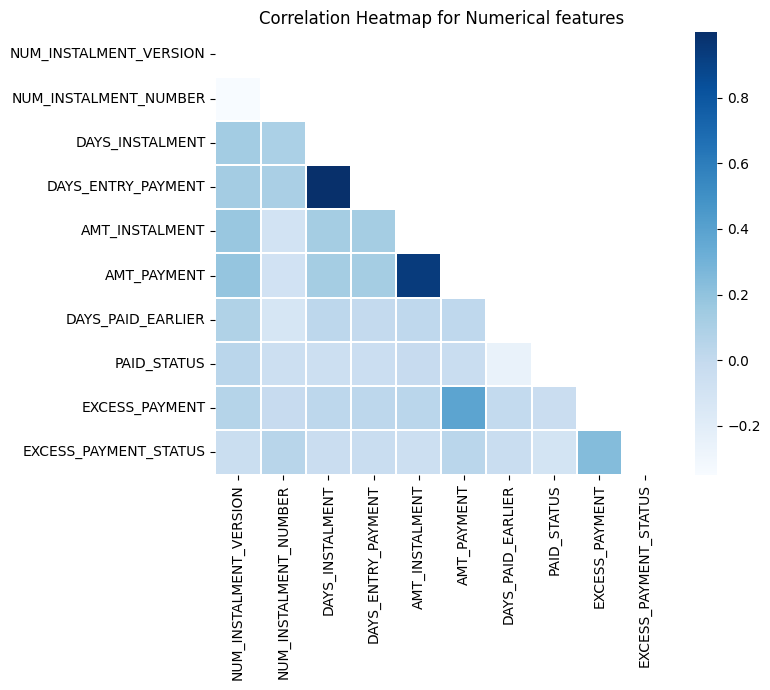

----------------------------------------------------------------------------------------------------


In [15]:
corr_mat = correlation_matrix(install_merged, ['SK_ID_CURR','SK_ID_PREV'], figsize = (8,7))
corr_mat.plot_correlation_matrix() 

In [16]:
#Seeing the top columns with highest phik-correlation with the target variable in installments_payments table
top_corr_target_df = corr_mat.target_top_corr()
print("-" * 100)
print("Columns with highest values of Phik-correlation with Target Variable are:")
display(top_corr_target_df)
print("-"*100)

interval columns not set, guessing: ['TARGET', 'NUM_INSTALMENT_VERSION']
interval columns not set, guessing: ['TARGET', 'NUM_INSTALMENT_NUMBER']
interval columns not set, guessing: ['TARGET', 'DAYS_INSTALMENT']
interval columns not set, guessing: ['TARGET', 'DAYS_ENTRY_PAYMENT']
interval columns not set, guessing: ['TARGET', 'AMT_INSTALMENT']
interval columns not set, guessing: ['TARGET', 'AMT_PAYMENT']
interval columns not set, guessing: ['TARGET', 'DAYS_PAID_EARLIER']
interval columns not set, guessing: ['TARGET', 'PAID_STATUS']
interval columns not set, guessing: ['TARGET', 'EXCESS_PAYMENT']
interval columns not set, guessing: ['TARGET', 'EXCESS_PAYMENT_STATUS']
----------------------------------------------------------------------------------------------------
Columns with highest values of Phik-correlation with Target Variable are:


,Column Name,Phik-Correlation
3,DAYS_ENTRY_PAYMENT,0.044692
2,DAYS_INSTALMENT,0.044676
7,PAID_STATUS,0.038282
1,NUM_INSTALMENT_NUMBER,0.022829
6,DAYS_PAID_EARLIER,0.007359
4,AMT_INSTALMENT,0.004201
5,AMT_PAYMENT,0.003394
0,NUM_INSTALMENT_VERSION,0.001619
8,EXCESS_PAYMENT,0.001382
9,EXCESS_PAYMENT_STATUS,0.000000


----------------------------------------------------------------------------------------------------


- The heatmap above shows the correlation between each feature in installments_payments table with the rest of the features.
- From the heatmap of correlation matrix, we see a couple of highly correlated features. These are:
 - - AMT_INSTALMENT and AMT_PAYMENT
 - - DAYS_INSTALMENT and DAYS_ENTRY_PAYMENT
- These two sets of correlated features are understandable, as they are actually the features as to when the installment was due to be paid vs when it was paid and also the amount that was due vs the amount that was paid.
- These features will be useful for creating new sets of completely uncorrelated features.
- The correlation of features with Target isn't noticeable, this shows the absence of a linear relationship between the feature and the target variable.

# Plotting Continuous Variables

Plotting 9 columns: ['NUM_INSTALMENT_VERSION', 'NUM_INSTALMENT_NUMBER', 'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT', 'AMT_INSTALMENT', 'AMT_PAYMENT', 'DAYS_PAID_EARLIER', 'EXCESS_PAYMENT', 'EXCESS_PAYMENT_STATUS']


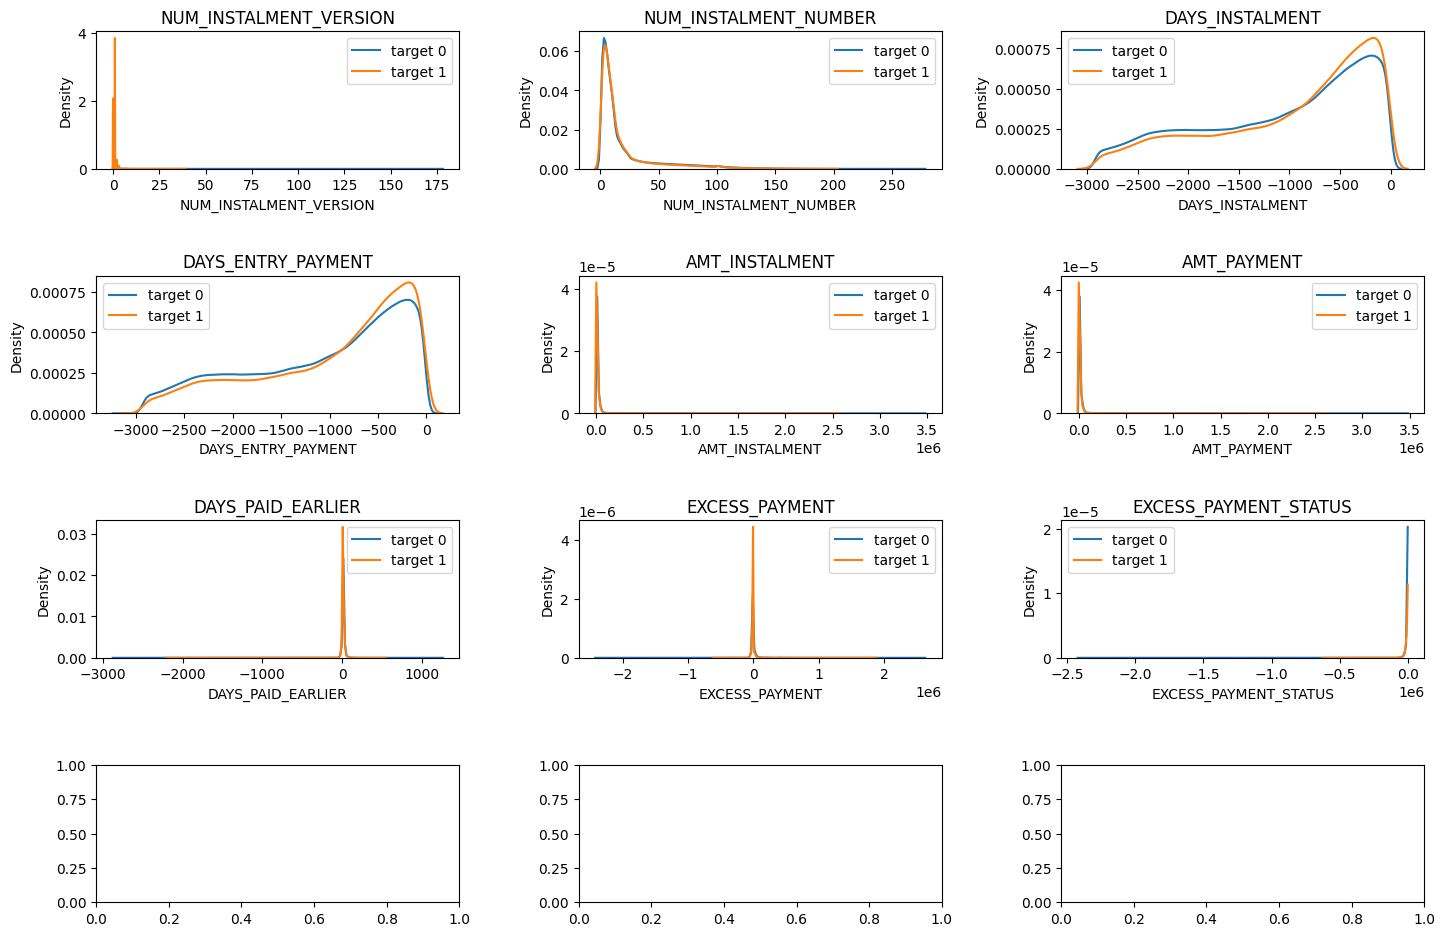

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

cols_to_plot = install_merged[:].var()[install_merged[:].var() > 0.1].index.tolist()
cols_to_plot.remove('SK_ID_CURR')
cols_to_plot.remove('SK_ID_PREV')

print(f'Plotting {len(cols_to_plot)} columns: {cols_to_plot}')

ncol, nrow = 3, len(cols_to_plot)//3 + 1

fig, ax = plt.subplots(nrow, ncol, figsize=(15, 10))  

for i, col in enumerate(cols_to_plot):
    sns.kdeplot(install_merged.loc[install_merged['TARGET'] == 0, col], label='target 0', ax=ax[i//ncol, i%ncol])
    sns.kdeplot(install_merged.loc[install_merged['TARGET'] == 1, col], label='target 1', ax=ax[i//ncol, i%ncol])
    ax[i//ncol, i%ncol].set_title(col)
    ax[i//ncol, i%ncol].legend()

plt.tight_layout(pad=3.0)  

# Hiển thị plot
plt.show()


- Defaulters have more days_entry_payment and days_installment_payment that is close to the application date of current loan.

## Distribution of PAID_STATUS with regard to TARGET

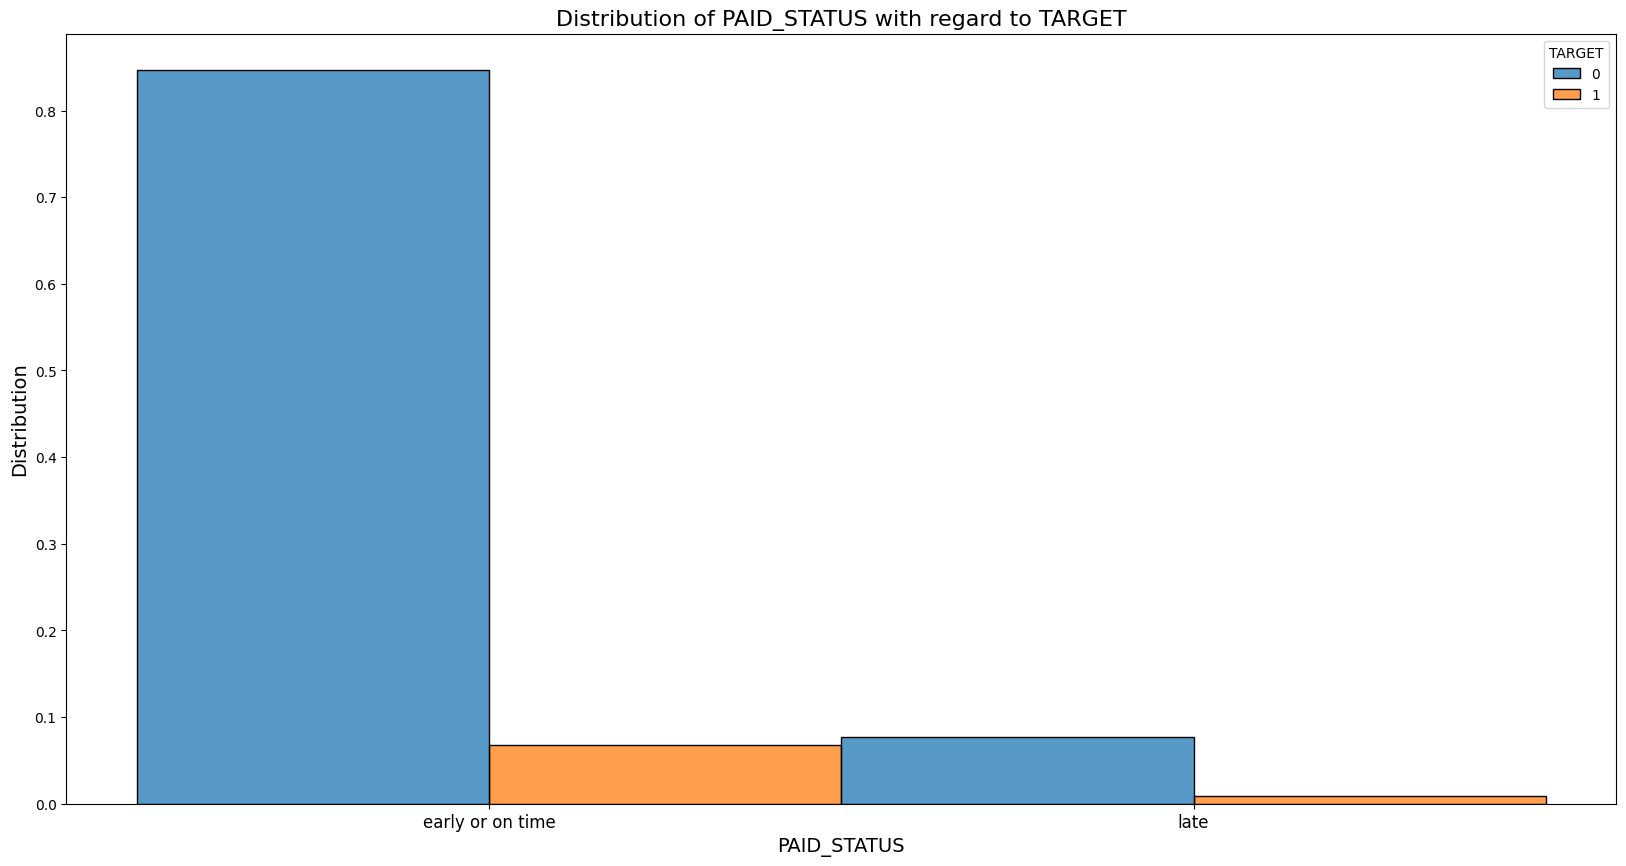

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 10))

sns.histplot(data=install_merged, x='PAID_STATUS', hue='TARGET', multiple='dodge', stat='probability', discrete=True)

plt.title('Distribution of PAID_STATUS with regard to TARGET', fontsize=16)
plt.xlabel('PAID_STATUS', fontsize=14)
plt.ylabel('Distribution', fontsize=14)

plt.xticks([0, 1], ['early or on time', 'late'], fontsize=12)

plt.show()


Most loans are repaid on time or even ahead of schedule (over 80%). However, some loans that are repaid on time or early still default, while some loans that are repaid late are still accepted. 
-> Check why the contracts that are repaid late are still being accepted.
